# TO-DO
Compare the results obtained with the DeepExplainer (maybe have to re-implement VGG) and my Shap-CAM implementation (try higher number of samples but keep vgg), also in a quantitative way. After that, continue with some Overleaf.


- Fine tune VGG on pascal VOC for classification
- Calculate shap values on different layers and plot the results
- Try to calculate some metrics on the test set (only using the upper layers for computational reasons)

In [90]:
%load_ext autoreload

%autoreload 2

import torch
from torchvision import transforms, models
import torch.nn as nn
import shap
from PIL import Image
import matplotlib.pyplot as plt
from masking import ChannelMeanMask, channel_mean_masking
import numpy as np
from my_shap import calculate_shap_values, calculate_shap_values_layer, plot_shap_values
from util import set_relu_inplace, cut_model_from_layer, cut_model_to_layer



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg11(pretrained=True)
model.to(device)
model.eval()
set_relu_inplace(model, inplace=False)

# Print an incremental integer each time the model is called
class Hook:
    def __init__(self):
        self.counter = 0

    def __call__(self, module, input, output):
        print(f"Called {self.counter} times")
        self.counter += 1
        
hook = Hook()
model.register_forward_hook(hook)



preprocess = transforms.Compose([
    transforms.Resize(256),                # Resize the image to 256 on the shortest side
    transforms.CenterCrop(224),            # Crop to 224x224
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


image = Image.open("test_image.jpg")    
# Load a test image from uRL
# import requests
# from io import BytesIO

# url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))
input_tensor = preprocess(image).unsqueeze(0)
print(input_tensor.shape)   
# Plot input tensor
# plt.imshow(input_tensor.squeeze().permute(1, 2, 0))
# plt.show()


# output = model(input_tensor)
# print(output.argmax())

# output_no_inplace = model_no_inplace(input_tensor)
# print(output_no_inplace.argmax())

# print(torch.allclose(output, output_no_inplace))

# Use SHAP with custom masking function
# explainer = shap.Explainer(model, masker=channel_mean_masking, max_evals=301057)
input_tensor_mean_per_channel = torch.mean(input_tensor, dim=(2, 3), keepdim=True)
background_data = input_tensor_mean_per_channel * torch.ones_like(input_tensor)
# print(f"input_tensor_mean_per_channel.shape = {input_tensor_mean_per_channel.shape}")
# print(f"background_data.shape = {background_data.shape}")
# print(model(background_data))

# def f(x: np.ndarray):
#     x = x.reshape(1, 3, 224, 224)
#     x = torch.tensor(x)
#     return model(x).numpy().flatten()

# shap_values = calculate_shap_values(model, input_tensor, 1000, 50, device=device)
explainer = shap.DeepExplainer(
    # (model, model.features[18]),
    model,
    background_data,
)
shap_values = explainer(input_tensor, check_additivity=False)
print(shap_values)

# Plot SHAP values
# shap_numpy = [np.transpose(s, (1, 2, 0)) for s in shap_values.values]
# shap.image_plot(shap_numpy, -input_tensor.squeeze().permute(1, 2, 0).numpy())
# plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 224, 224])
Called 0 times
Called 1 times
Called 2 times
Called 3 times
Called 4 times
Called 5 times
Called 6 times
Called 7 times
Called 8 times
Called 9 times
Called 10 times
Called 11 times
Called 12 times
Called 13 times
Called 14 times
Called 15 times
Called 16 times
Called 17 times
Called 18 times
Called 19 times
Called 20 times
Called 21 times
Called 22 times
Called 23 times
Called 24 times
Called 25 times
Called 26 times
Called 27 times
Called 28 times
Called 29 times
Called 30 times
Called 31 times
Called 32 times
Called 33 times
Called 34 times
Called 35 times
Called 36 times
Called 37 times
Called 38 times
Called 39 times
Called 40 times
Called 41 times
Called 42 times
Called 43 times
Called 44 times
Called 45 times
Called 46 times
Called 47 times
Called 48 times
Called 49 times
Called 50 times
Called 51 times
Called 52 times
Called 53 times
Called 54 times
Called 55 times
Called 56 times
Called 57 times
Called 58 times
Called 59 times
Called 60 times
Calle

In [60]:
# Print all model layers
for name, module in model.named_modules():
    print(name, module)

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [93]:
output = model(input_tensor)
print(output.argmax())

Called 1001 times
tensor(207)


In [33]:
shap_values.data.shape

torch.Size([1, 3, 224, 224])

In [81]:
shap_values.values.shape

(1, 3, 224, 224, 1000)

In [82]:
shap_values.values[:, :,:,:,output.argmax()].shape
np.transpose(shap_values.values[0, :,:,:,output.argmax()], (1, 2, 0))

array([[[-3.65392934e-03, -5.93222119e-03, -1.72007782e-03],
        [-2.41397251e-03, -4.23889421e-03,  4.99144429e-04],
        [ 5.33830142e-04,  4.40385804e-04, -4.11328510e-04],
        ...,
        [ 1.01417198e-03,  1.19016203e-03,  3.10245971e-03],
        [-5.48599579e-04,  3.42444313e-04,  2.96696112e-03],
        [-1.47957107e-04,  2.09302336e-04,  1.92741246e-03]],

       [[-1.65819505e-03, -9.65665444e-04,  5.92690194e-03],
        [-1.23162265e-03, -1.31633307e-03,  4.67763469e-03],
        [-6.89919048e-04, -4.98123991e-04,  5.27552038e-04],
        ...,
        [ 6.87122857e-03,  6.13790145e-03,  5.22823073e-04],
        [-1.01397501e-03,  1.51700992e-03,  4.73620649e-03],
        [-2.53656297e-04,  6.64090912e-04,  2.43682135e-03]],

       [[ 1.46330902e-04,  1.40143663e-03,  3.35338246e-03],
        [-1.69923689e-04,  4.98194713e-04,  2.33439007e-03],
        [-1.53607572e-04, -6.08820374e-05, -1.47701474e-03],
        ...,
        [ 9.15189367e-03,  5.36868675e-03,

In [50]:
input_tensor.squeeze().permute(1,2,0)

tensor([[[ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         ...,
         [ 0.0056, -0.2325, -1.0201],
         [-0.0116, -0.2500, -1.0201],
         [-0.0116, -0.2500, -1.0201]],

        [[ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         ...,
         [ 0.0056, -0.2325, -1.0201],
         [-0.0116, -0.2500, -1.0201],
         [-0.0116, -0.2500, -1.0201]],

        [[ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         [ 0.5193,  0.2052, -0.6018],
         ...,
         [ 0.0056, -0.2325, -1.0201],
         [-0.0116, -0.2500, -1.0201],
         [-0.0116, -0.2500, -1.0201]],

        ...,

        [[ 0.7077,  0.8529,  0.1476],
         [ 0.7248,  0.8529,  0.1999],
         [ 0.9132,  0.9930,  0.4265],
         ...,
         [ 0.8789,  0.8179,  0.9668],
         [ 1.6495,  1.6232,  1.8731],
         [ 1.9578,  1.9734,  2.2043]],

        [[

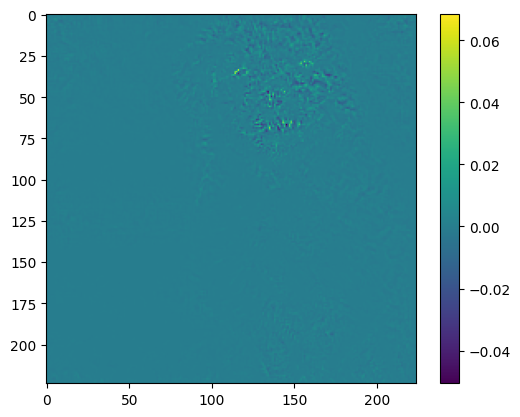

In [83]:
plt.imshow(np.transpose(shap_values.values[0, :,:,:,output.argmax()], (1, 2, 0)).mean(axis=2))
plt.colorbar()

In [66]:
# Get the top 5 classes
_, indices = torch.topk(output, 5)
print(indices)

tensor([[207, 257, 222, 260, 208]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


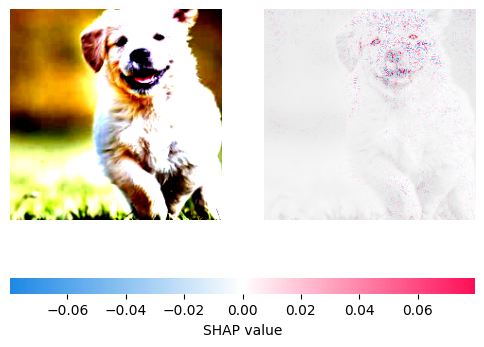

In [92]:
# Plot the shapely values for the predicted class
shap.image_plot(np.transpose(shap_values.values[0, :,:,:,207], (1, 2, 0)), input_tensor.squeeze().permute(1, 2, 0).numpy(), show=False)

plt.savefig('plot2.pdf', format='pdf', dpi=700)

In [68]:
model1 = cut_model_to_layer(model, "features.8", included=True)
model2 = cut_model_from_layer(model, "features.8", included=False)

print(input_tensor.shape)
output1 = model1(input_tensor)
print(output1.shape)
output2 = model2(output1)
print(output2.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 256, 56, 56])
torch.Size([1, 1000])


In [77]:
# shap_values = calculate_shap_values(model, input_tensor, 1000, n_samples=50, device=device)
shap_values = calculate_shap_values_layer(model, input_tensor,"features.16", 1000, n_samples=50, device=device)

  0%|          | 0/196 [00:00<?, ?it/s]

In [92]:
shap_values.shape

torch.Size([196, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


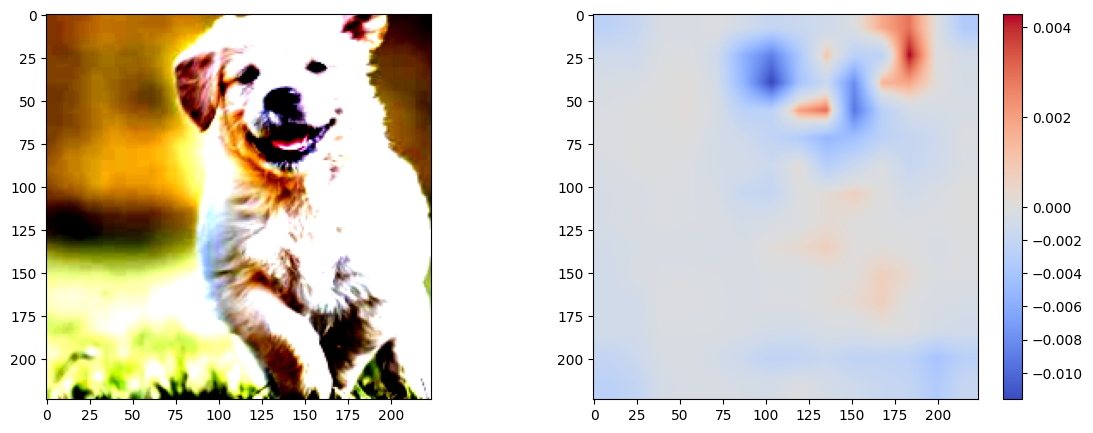

In [100]:
plot_shap_values(input_tensor, shap_values, 207)

In [102]:
from torchvision.datasets import VOCDetection

dl = VOCDetection(root="data", year="2007", image_set="val", download=True)

100%|██████████| 460032000/460032000 [01:05<00:00, 6993207.58it/s]


Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [122]:
for image, details in dl:
    objects = details["annotation"]["object"]
    for obj in objects:
        print(obj)
        bounding_box = obj["bndbox"]

        x_min = int(bounding_box["xmin"])
        y_min = int(bounding_box["ymin"])
        x_max = int(bounding_box["xmax"])
        y_max = int(bounding_box["ymax"])
        
        image_obj = image.crop((x_min, y_min, x_max, y_max))    
    break

{'name': 'chair', 'pose': 'Rear', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '263', 'ymin': '211', 'xmax': '324', 'ymax': '339'}}
{'name': 'chair', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '165', 'ymin': '264', 'xmax': '253', 'ymax': '372'}}
{'name': 'chair', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '1', 'bndbox': {'xmin': '5', 'ymin': '244', 'xmax': '67', 'ymax': '374'}}
{'name': 'chair', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '241', 'ymin': '194', 'xmax': '295', 'ymax': '299'}}
{'name': 'chair', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '1', 'bndbox': {'xmin': '277', 'ymin': '186', 'xmax': '312', 'ymax': '220'}}


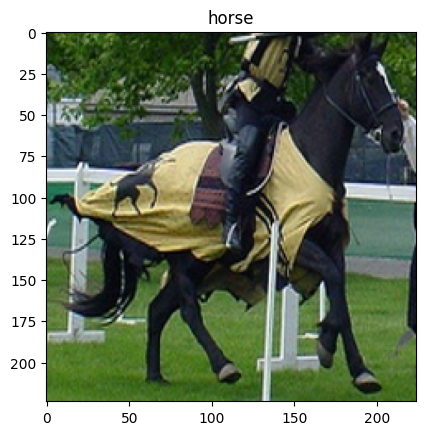

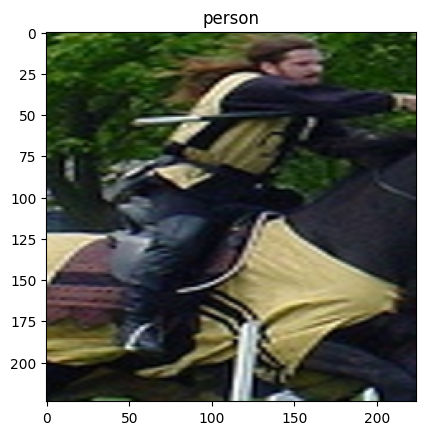

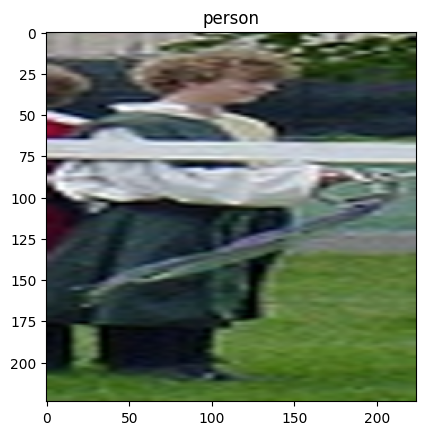

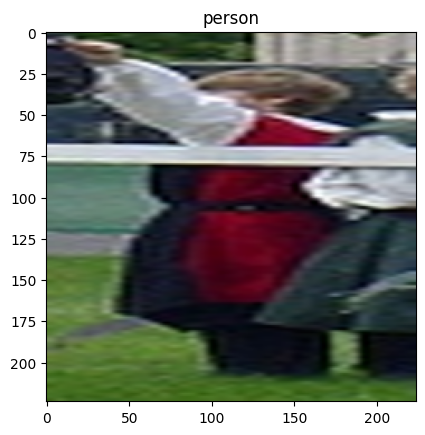

In [120]:
for obj in dl[2][1]["annotation"]["object"]:
    bounding_box = obj["bndbox"]
    # Cut the image
    x_min = int(bounding_box["xmin"])
    y_min = int(bounding_box["ymin"])
    x_max = int(bounding_box["xmax"])
    y_max = int(bounding_box["ymax"])
    image = dl[2][0].crop((x_min, y_min, x_max, y_max))
    
    # Plot the image
    # Upsscale to 224x224
    image = image.resize((224, 224))
    
    plt.title(obj["name"])
    plt.imshow(image)
    plt.show()

In [18]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px", split="validation")

label_conversion = {
    0: 0,
    1: 217, # English Springer
    2: 482,# Cassette player,
    3: 491,# Chain saw
    4: 497,# Church
    5: 566,# French horn
    6: 569, # Garbage truck
    7: 571,# Gas pump
    8: 574,# Golf ball
    9: 701,# Parachute
}

In [19]:
for i in range(len(ds)):
    ds[i]["label"] = label_conversion[ds[i]["label"]]

In [24]:
ds[10]["label"]

2

In [22]:
def plot_shap_image(shap_values, index):
    values = np.transpose(shap_values.values[0][:,:,:,index], (1, 2, 0))
    # Normalize between -1 and 1
    values = values / np.max(np.abs(values))
    plt.imshow(values)
    plt.colorbar()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


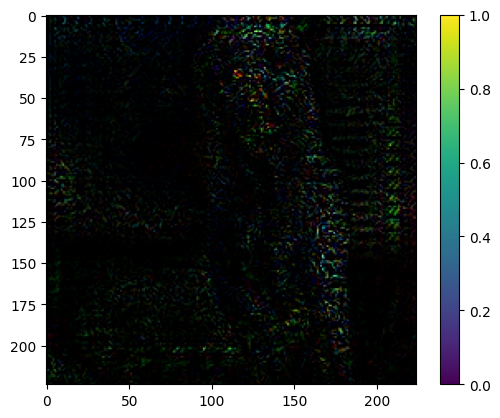

In [48]:
plot_shap_image(shap_values, 463)